# Making geologic cross sections from well logs

In [ ]:
# let's import some packages we are going to use
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import lasio
from textwrap import wrap  # for making pretty well names
from multiprocessing import Pool

%matplotlib inline

### Where did this data come from?
The cell below reads in the LAS file names using glob, and then reads in some fake tops I made up for the cross section. These are close to the top of the Niobrara Formation in the Denver Basin of southeast Wyoming. Well log LAS files are from the [WOGCC](http://pipeline.wyo.gov/legacywogcce.cfm) and tops are eyeballed by me and are probably way off.

In [80]:
wells = []
year = 2018
for name in glob.glob(f"logs/{year}/*.las"):
    wells.append(name)

Now let's create a figure and read in well log. We then plot each log by subsea depth so we can see a structural cross section

In [40]:
def get_depth(well_log):
    if well_log is None:
        return None
    if "DEPT" in well_log.keys():
        return well_log["DEPT"]
    if "DEPTH" in well_log.keys():
        return well_log["DEPTH"]
    return None

def get_gamma(well_log):
    if well_log is None:
        return None
    if "GR" in well_log.keys():
        return well_log["GR"]
    if "GRGC" in well_log.keys():
        return well_log["GRGC"]
    if "GAMMA" in well_log.keys():
        return well_log["GAMMA"]
    if "GAMMA:1" in well_log.keys():
        return well_log["GAMMA:1"]
    return None

def get_well(well_log):
    try:
        return well_log.well["WELL"]
    except:
        return well_log.well["WELL:1"]

We are interested in Extracting out the GAMMA attribute for now

In [41]:
len(wells)

3053

In [42]:
fig = plt.figure(figsize=(10, 15))  # set our figure size

for i, j in enumerate(range(21, 28)):  # we read in the 7 logs
    well_log = lasio.read(wells[j])  # this reads in the log
    ax = fig.add_subplot(
        171 + i
    )  # creates a subplot that the curve will be plotted in
    try:
        ax.plot(
            get_gamma(well_log)[::50],
            get_depth(well_log)[::50],
        )
    except Exception as e:
        print(e)
        print()
        pass
    # this does the plotting, we plot gamma ray as a function of depth. note we subtract the kelly bushing elevation (EKB) to get subsea depth
    # we also downsample the logs so they plot faster
    ax.invert_yaxis()
    # flip the axis so downhole is down in the figure
    ax.axis("off")
    # this gets rid of the axis so they look clean
    ax.set_title("\n".join(wrap(get_well(well_log).value, 10)))
    # and let's go ahead and add titles to each log for fun

KeyError: 'No ~ sections found. Is this a LAS file?'

<Figure size 720x1080 with 0 Axes>

That's a nice little cross section above, but can we make it better looking? More geologic styling to the gamma-ray curves is possible. Let's investigate this possibility. We will take our plot from above, and we're going to color between the curve and the right hand side. For a full breakdown look at the [coloring well logs notebook](https://github.com/jessepisel/5minutesofpython/blob/master/Well%20log%20plots/gamma%20ray%20colors.ipynb). One last thing we want to do is remove the whitespace between the logs so it looks better and we do that in the last line of the cell

In [43]:
import matplotlib as mpl  # for making a colormap

cmap = mpl.cm.bone_r  # select our color map

fig = plt.figure(figsize=(10, 12))  # set our figure size


for i, j in enumerate(range(14, 21)):  # we read in the 7 logs
    well_log = lasio.read(wells[j])  # this reads in the log
    try:
        x = get_gamma(well_log)[::50]  # assign the GR values to x
        x[np.isnan(x)] = 0
        y = get_depth(well_log)[::50] #% assign the depth values to y
        z = (
             x
        )  # create a third variable for the colors, you could have fun and make this another curve as well
    except Exception as E:
        print(wells[i])
        print(E)
    normalize = mpl.colors.Normalize(vmin=z.min(), vmax=z.max())

    ax = fig.add_subplot(
        171 + i
    )  # creates a subplot that the curve will be plotted in
    ax.plot(x, y, color="gray")
    # this does the plotting, we plot gamma ray as a function of depth. note we subtract the kelly bushing elevation (EKB) to get subsea depth
    ax.invert_yaxis()
    # flip the axis so downhole is down in the figure

    for k in range(x.size - 1):
        plt.fill_betweenx(
            [y[k], y[k + 1]],
            [x[k], x[k + 1]],
            x2=z.max(),
            color=cmap(normalize(z[k])),
        )
    # let's plot the fake tops from the csv file as a horizontal line, don't forget to subtract the KB elevation for subsea depth
    ax.axis("off")
    # this gets rid of the axis so they look clean
    ax.set_title("\n".join(wrap(well_log.well["WELL"].value, 10)))
    # and let's go ahead and add titles to each log for fun
plt.subplots_adjust(wspace=0, hspace=0)

KeyError: 'No ~ sections found. Is this a LAS file?'

<Figure size 720x864 with 0 Axes>

What else is in the well_log dataframe??

In [44]:
example_log = lasio.read(wells[0])
wells[0]

'logs/2014/1044839666.las'

Lets drop NaN's to see what is concistently there


In [45]:
example_df = example_log.df()
example_df

,BVTX,AVTX,RXORT,CILD,RLL3,SP,RILD,RILM,DCAL,RHOB,RHOC,DPOR,CNLS,GR,DGA,MCAL,MI,MN
DEPT,,,,,,,,,,,,,,,,,,
-1.0,0.0,0.0,NaN,NaN,100000.0,NaN,NaN,NaN,2.8636,-1.5648,-3.1316,249.9881,-4.9571,352.6158,NaN,NaN,NaN,NaN
-0.5,0.0,0.0,-28.7733,0.0000,50000.0,-333.0000,50000.0000,-499.6250,1.4312,-0.6938,-1.4650,119.8116,-2.4975,146.9875,NaN,NaN,NaN,NaN
0.0,0.0,0.0,-28.7733,0.0000,50000.0,-333.0000,50000.0000,-499.6250,1.4312,-0.6938,-1.4650,119.8116,-2.4975,146.9875,NaN,NaN,NaN,NaN
0.5,0.0,0.0,-392.5096,66.8215,100000.0,-999.0000,14.9652,NaN,2.8613,-0.7261,-2.3105,200.9407,-4.8093,253.7774,NaN,NaN,NaN,NaN
1.0,0.0,0.0,-403.8156,117.4983,100000.0,-999.0000,8.5108,NaN,2.8611,-0.2107,-1.7720,170.7992,-4.4559,235.1165,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4723.5,0.0,0.0,0.0000,0.0000,NaN,-50.2496,100000.0000,7.3005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.9624,2.2530,3.7520
4724.0,0.0,0.0,0.0000,0.0000,NaN,-50.7174,100000.0000,7.5690,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.9617,2.2485,3.7498
4724.5,0.0,0.0,0.0000,0.0000,NaN,-51.2160,100000.0000,8.1534,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.9583,2.2406,3.7426


In [46]:
well_log.df().dropna()["GR"]

NameError: name 'well_log' is not defined

In [47]:
well_log.df()["GR"]

NameError: name 'well_log' is not defined

In [69]:
def plot_well(file_name):
    fig = plt.figure(figsize=(2,10))
    well_log = lasio.read(file_name)  # this reads in the log
    try:
        x = get_gamma(well_log)[::50]  # assign the GR values to x
        print(type(x))
        x[np.isnan(x)] = 0
        y = get_depth(well_log)[::50] #% assign the depth values to y
        z = (
            x
        )  # create a third variable for the colors, you could have fun and make this another curve as well
    except Exception as E:
        print(file_name)
        print(E)
        plt.close(fig)
        return
    normalize = mpl.colors.Normalize(vmin=z.min(), vmax=z.max())

    plt.plot(x, y, color="gray")
    ax = plt.gca()
    # this does the plotting, we plot gamma ray as a function of depth. note we subtract the kelly bushing elevation (EKB) to get subsea depth
    ax.invert_yaxis()
    # flip the axis so downhole is down in the figure

    for j in range(x.size - 1):
        plt.fill_betweenx(
            [y[j], y[j + 1]],
            [x[j], x[j + 1]],
            x2=z.max(),
            color=cmap(normalize(z[j])),
        ) 
    # let's plot the fake tops from the csv file as a horizontal line, don't forget to subtract the KB elevation for subsea depth
    ax.axis("off")
    # this gets rid of the axis so they look clean
    ax.set_title("\n".join(wrap(f'{get_well(well_log).value}', width=10)))
    # and let's go ahead and add titles to each log for fun
    well_name = get_well(well_log).value
    if type(well_name) == type([]):
        well_name = "".join(well_name)
    else:
        well_name = str(well_name)
    # plt.savefig("well_figs/" + well_name.replace('/', '') + ".png", transparent=True)
    plt.close(fig)

FileNotFoundError: [Errno 2] No such file or directory: 'well_figs/Merle #1-8.png'

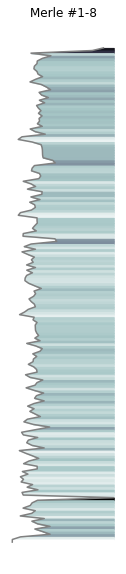

In [49]:
for i, well in enumerate(wells):
    plot_well(well)

In [50]:
def get_county(well_log):
    if well_log is None:
        return "NA"
    if "CNTY" in well_log.well:
        return well_log.well["CNTY"].value.upper()
    if "CNTY." in well_log.well:
        return well_log.well["CNTY."].value.upper()
    return f"NA"

In [51]:
# Some of these Errored out when reading, we can skip over those for now and look at how many errors we have
well_logs = []
errors = 0

def add_log(file):
    global errors, well_logs
    try:
        return lasio.read(file)
    except Exception as e:
        print(f"{e} Error number: {errors} on file {file}")
        errors += 1
        return None

pool = Pool()
well_logs = list(pool.imap(add_log, wells));

'No ~ sections found. Is this a LAS file?' Error number: 0 on file logs/2014/1044925140.las'No ~ sections found. Is this a LAS file?' Error number: 0 on file logs/2014/1044945015.las'No ~ sections found. Is this a LAS file?' Error number: 0 on file logs/2014/1044916277.las'No ~ sections found. Is this a LAS file?' Error number: 0 on file logs/2014/1044944950.las'No ~ sections found. Is this a LAS file?' Error number: 0 on file logs/2014/1044931341.las
'No ~ sections found. Is this a LAS file?' Error number: 0 on file logs/2014/1044955926.las
'No ~ sections found. Is this a LAS file?' Error number: 0 on file logs/2014/1044910483.las


'No ~ sections found. Is this a LAS file?' Error number: 0 on file logs/2014/1044907883.las'No ~ sections found. Is this a LAS file?' Error number: 0 on file logs/2014/1044916339.las

'No ~ sections found. Is this a LAS file?' Error number: 0 on file logs/2014/1044907720.las'No ~ sections found. Is this a LAS file?' Error number: 0 on file logs/2014/104490

Process ForkPoolWorker-17:
Process ForkPoolWorker-6:
Process ForkPoolWorker-18:
Process ForkPoolWorker-32:
Process ForkPoolWorker-29:
Process ForkPoolWorker-4:
Process ForkPoolWorker-19:
Process ForkPoolWorker-28:
Process ForkPoolWorker-8:
Process ForkPoolWorker-10:
Process ForkPoolWorker-11:
Process ForkPoolWorker-25:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-20:
Process ForkPoolWorker-24:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Process ForkPoolWorker-5:
  File "/usr/lib/python3.9/multipr

KeyboardInterrupt: 

Process ForkPoolWorker-31:
Process ForkPoolWorker-1:
Process ForkPoolWorker-2:
  File "/usr/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Process ForkPoolWorker-30:
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Process ForkPoolWorker-15:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-22:
Process ForkPoolWorker-3:
Process ForkPoolWorker-21:
Process ForkPoolWorker-16:
Process ForkPoolWorker-27:
Process ForkPoolWorker-26:
Process ForkPoolWorker-14:
Process ForkPoolWorker-13:
Process ForkPoolWorker-9:
Process ForkPoolWorker-7:
  File "/usr/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.9/multi

In [ ]:
errors

'No ~ sections found. Is this a LAS file?' Error number: 0 on file logs/2014/1044907541.las
'No ~ sections found. Is this a LAS file?' Error number: 0 on file logs/2014/1044913557.las'No ~ sections found. Is this a LAS file?' Error number: 0 on file logs/2014/1044892196.las

'No ~ sections found. Is this a LAS file?' Error number: 1 on file logs/2014/1044913874.las'No ~ sections found. Is this a LAS file?' Error number: 1 on file logs/2014/1044891336.las

'No ~ sections found. Is this a LAS file?' Error number: 0 on file logs/2014/1044891165.las
'No ~ sections found. Is this a LAS file?' Error number: 0 on file logs/2014/1044913758.las
'No ~ sections found. Is this a LAS file?' Error number: 0 on file logs/2014/1044956071.las
'No ~ sections found. Is this a LAS file?' Error number: 0 on file logs/2014/1044956426.las
'No ~ sections found. Is this a LAS file?' Error number: 1 on file logs/2014/1044907131.las
'No ~ sections found. Is this a LAS file?' Error number: 0 on file logs/2014/104

/home/fastfist/.local/share/virtualenvs/transformers-kgQS_UHh/lib/python3.9/site-packages/lasio/las.py:284: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  arr[arr == provisional_null] = np.nan


'No ~ sections found. Is this a LAS file?' Error number: 1 on file logs/2014/1044907165.las
'No ~ sections found. Is this a LAS file?' Error number: 1 on file logs/2014/1044916456.las
'No ~ sections found. Is this a LAS file?' Error number: 0 on file logs/2014/1044956367.las
'No ~ sections found. Is this a LAS file?' Error number: 2 on file logs/2014/1044931040.las
'No ~ sections found. Is this a LAS file?' Error number: 3 on file logs/2014/1044956551.las
'No ~ sections found. Is this a LAS file?' Error number: 4 on file logs/2014/1044913765.las
'No ~ sections found. Is this a LAS file?' Error number: 4 on file logs/2014/1044956242.las
'No ~ sections found. Is this a LAS file?' Error number: 5 on file logs/2014/1044925228.las
'No ~ sections found. Is this a LAS file?' Error number: 4 on file logs/2014/1044913559.las
'No ~ sections found. Is this a LAS file?' Error number: 6 on file logs/2014/1044906750.las'No ~ sections found. Is this a LAS file?' Error number: 4 on file logs/2014/1044

/home/fastfist/.local/share/virtualenvs/transformers-kgQS_UHh/lib/python3.9/site-packages/lasio/las.py:284: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  arr[arr == provisional_null] = np.nan


Cannot reshape ~A data size (697,) into 8 columns Error number: 15 on file logs/2014/1044817556.las
'No ~ sections found. Is this a LAS file?' Error number: 20 on file logs/2014/1044882033.las

'No ~ sections found. Is this a LAS file?' Error number: 22 on file logs/2014/1044916805.las
'No ~ sections found. Is this a LAS file?' Error number: 24 on file logs/2014/1044913763.las
'No ~ sections found. Is this a LAS file?' Error number: 25 on file logs/2014/1044906994.las
'No ~ sections found. Is this a LAS file?' Error number: 23 on file logs/2014/1044891645.las'No ~ sections found. Is this a LAS file?' Error number: 32 on file logs/2014/1044882083.las

Line 108 (section ~PARAMETER INFORMATION): "580-225-4300 :Remarks Line 8" Error number: 23 on file logs/2014/1044831148.las'No ~ sections found. Is this a LAS file?' Error number: 24 on file logs/2014/1044882060.las

'No ~ sections found. Is this a LAS file?' Error number: 31 on file logs/2014/1044913552.las
'No ~ sections found. Is this a

In [ ]:
def extract_all(well_log, uid):
    depth = get_depth(well_log)
    gamma = get_gamma(well_log)
    if depth is None:
        return pd.DataFrame() # If no time series is avaliable, we can't use it
    index_df = pd.DataFrame(dict(depth=depth, well_id=uid))
    index = pd.MultiIndex.from_frame(index_df)
    county = get_county(well_log)

    return pd.DataFrame(dict(gamma=gamma, County=county), index=index)
dataframes = []
for uid, well_log in enumerate(well_logs):
    
    dataframes.append(extract_all(well_log, uid))

In [ ]:
len(dataframes)

In [ ]:
final_df = pd.concat(dataframes)

We found a bunch of typos... lets correct those

In [ ]:
final_df

In [ ]:
corrections = {
    "ELI WIRELINE": "NA",
    "LGAN": "LOGAN",
    "SALINA": "SALINE",
    "HARPER CO": "HARPER",
    "HARPER CO.": "HARPER",
    "SUMMER": "SUMNER",
    "SEDOWICK": "SEDGWICK",
    "ELLS": "ELLIS",
    "NESS CO.": "NESS",
    '': "NA",
    "HODGMAN": "HODGEMAN",
    "USA" : "NA",
    "KANSAS" : "NA",
    "RUSSEL" : "RUSSELL",
    "PRATT COUNTY" : "PRATT",
    "WITCHITA" : "WICHITA",
    "RUCH" : "RUSH",
    "RAWLINGS" : "RAWLINS",
}
for key, value in corrections.items():
    final_df.loc[final_df["County"] == key] = value

In [ ]:
len(counties) # This also contains the NA value, so I think this is good

In [ ]:
final_df.groupby(level="well_id").first().drop("gamma", axis=1).value_counts()

In [ ]:
final_df

In [ ]:
final_df.to_csv(f"export_csv/{year}.csv")

Turn dataframe into uniques based on well identifier to count frequencies

In [ ]:
convert_to_single = lambda x: [ z[0] for z in x]

In [ ]:
freq_count = final_df.groupby(level="well_id").first().drop("gamma", axis=1).value_counts()
freq_df = pd.DataFrame({"County": convert_to_single(freq_count.keys()), "Frequency": freq_count.values})
freq_df = freq_df.sort_values(by="Frequency", ascending=False)
freq_df = freq_df.reset_index(drop=True)
freq_df

In [ ]:
freq_df["Percent"] = freq_df['Frequency'] /freq_df["Frequency"].sum() * 100
freq_df

In [ ]:
fig = plt.figure(figsize=(6,17))
plt.yticks(range(len(freq_df)), freq_df["County"])
plt.barh(range(len(freq_df)), freq_df["Percent"])

In [ ]:
freq_df[freq_df["County"] == "NA"]

In [ ]:
freq_df.head(10)

In [ ]:
import geopandas as gpd
kansas_map = gpd.read_file("kansas.zip")
kansas_map.plot()

We want to find the county codes for each

In [ ]:
fpis = pd.read_csv("fips.csv")
fpis

In [ ]:
freq_df

In [ ]:
freq_df["COUNTYFP"] = 0

In [ ]:
freq_df[freq_df["County"] == "KANSAS"]

In [ ]:
for index, county in freq_df["County"].iteritems():
    name = county.capitalize() + " County"
    if name == "Mcpherson County":
        name = "McPherson County"
    q1 = fpis[fpis["name"] == name]
    try:
        freq_df.loc[index, "COUNTYFP"] = str(q1[q1["state"] == "KS"]["fips"].iloc[0])[2:]
    except Exception as e:
        print("None - " + county)

Now we can join the two together

In [ ]:
kansas_map.plot()

In [ ]:
freq_df[freq_df["County"] == "NA"]

In [ ]:
density_map = kansas_map
density_map = density_map.merge(freq_df, on = "COUNTYFP", how = "left")
density_map.plot()

In [ ]:
density_map.Frequency.unique()

In [ ]:
density_map = density_map.fillna(0)

In [ ]:
density_map["Frequency"].unique()

density_map.plot(column="Frequency", cmap = 'inferno', legend=True)
plt.title(f"Kansas Well County Distribution - {year}")
plt.savefig(f"kansas_map {year}.png")

In [ ]:
kansas_map["COUNTYFP"]

In [ ]:
freq_df["COUNTYFP"].unique()

# Lets breakdown the exported CSVs

In [161]:
frame = pd.read_csv(f"export_csv/{year}.csv", index_col=[1, 0])
frame = frame.sort_index()
frame

gamma   County
well_id depth                   
0       95.0    92.7310  WOODSON
        95.5    94.3767  WOODSON
        96.0    89.6473  WOODSON
        96.5    86.6330  WOODSON
        97.0    90.6803  WOODSON
...                 ...      ...
355     4655.5      NaN    SCOTT
        4656.0      NaN    SCOTT
        4656.5      NaN    SCOTT
        4657.0      NaN    SCOTT
        4657.5      NaN    SCOTT

[3217922 rows x 2 columns]

In [185]:
one_well = frame.loc[3]
one_well

,gamma,County
depth,,
295.0,95.3810,LOGAN
295.5,94.1448,LOGAN
296.0,91.7332,LOGAN
296.5,89.7796,LOGAN
297.0,90.9479,LOGAN
...,...,...
4703.5,NaN,LOGAN
4704.0,NaN,LOGAN
4704.5,NaN,LOGAN


Text(0.5, 1.0, 'Location 4')

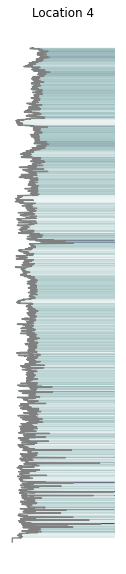

In [186]:
fig = plt.figure(figsize=(2,10))


x = one_well["gamma"].values
x[np.isnan(x)] = 0
y = one_well.index.values #% assign the depth values to y
z = (
    x
)  # create a third variable for the colors, you could have fun and make this another 
normalize = mpl.colors.Normalize(vmin=z.min(), vmax=z.max())
plt.plot(x, y, color="gray")
ax = plt.gca()
# this does the plotting, we plot gamma ray as a function of depth. note we subtract the kelly bushing elevation (EKB) to get subsea depth
ax.invert_yaxis()
# flip the axis so downhole is down in the figure

for j in range(x.size - 1):
    plt.fill_betweenx(
        [y[j], y[j + 1]],
        [x[j], x[j + 1]],
        x2=z.max(),
        color=cmap(normalize(z[j]))
    ) 
# let's plot the fake tops from the csv file as a horizontal line, don't forget to subtract the KB elevation for subsea depth
ax.axis("off")
# this gets rid of the axis so they look clean
ax.set_title("Location 4")
# and let's go ahead and add titles to each log for fun

# Training on a single well

In [179]:
import darts
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm

from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf

In [184]:
len(frame.loc[0]["gamma"])

2643